# snRNA diversity exploration

In [2]:
# First portion (biomaRt and initial GenomicRanges) is adapted from HD script, later parts are new
# In most cases, did not do all exploration with all snRNAs/variants, just picked a few examples

In [2]:
# Load necessary packages

library(biomaRt)
library(GenomicRanges)
library(Biostrings)
library(ggplot2)
library(psych)

Warning message:
“package ‘GenomicRanges’ was built under R version 3.5.1”Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique

In [3]:
# Pull all snRNA genes from most recent genome assembly

ensembl <- useMart("ENSEMBL_MART_ENSEMBL")
ensembl <- useDataset("hsapiens_gene_ensembl",mart=ensembl)
listMarts(ensembl)
listAttributes(ensembl, page="feature_page")

tmp <- getBM(attributes=c("ensembl_gene_id", "hgnc_symbol", "gene_biotype", "rfam"),
             filters="biotype",
             values="snRNA", 
             mart=ensembl)
table(tmp$rfam)


biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 94
ENSEMBL_MART_MOUSE,Mouse strains 94
ENSEMBL_MART_SNP,Ensembl Variation 94
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 94


name,description,page
ensembl_gene_id,Gene stable ID,feature_page
ensembl_gene_id_version,Gene stable ID version,feature_page
ensembl_transcript_id,Transcript stable ID,feature_page
ensembl_transcript_id_version,Transcript stable ID version,feature_page
ensembl_peptide_id,Protein stable ID,feature_page
ensembl_peptide_id_version,Protein stable ID version,feature_page
ensembl_exon_id,Exon stable ID,feature_page
description,Gene description,feature_page
chromosome_name,Chromosome/scaffold name,feature_page
start_position,Gene start (bp),feature_page



        RF00003 RF00004 RF00007 RF00015 RF00020 RF00026 RF00066 RF00548 RF00618 
      1     178      93       2      99      33    1434     160       6      19 
RF00619 
     44 

In [4]:
## Filter for just the snRNAs of interest: 
## Major spliceosome: RF00003=U1, RF00004=U2, RF00015=U4, RF00020=U5, RF00026=U6

tmp <- tmp[tmp$rfam %in% c("RF00003", "RF00004", "RF00015", "RF00020", "RF00026"), ]
table(tmp$rfam)


RF00003 RF00004 RF00015 RF00020 RF00026 
    178      93      99      33    1434 

In [5]:
# Get gene info

genes <- getBM(attributes=c(colnames(tmp), "chromosome_name", "start_position", "end_position", "strand"), 
               filters="ensembl_gene_id",
               values=tmp$ensembl_gene_id,
               mart=ensembl)

In [6]:
## 155 are located on 'odd' chomosomes (patches). These incluse a lot of the snRNAs with no 
## hgnc symbol, although about 80 still remain

nrow(genes[grep("CHR", genes$chromosome_name),])

genes <- genes[genes$chromosome_name %in% c(1:22, "X", "Y"),]

## => 1673 remain. Some of these were duplicates of genes that were also on some of the main 
## chromosomes anyway

[1] 155

In [7]:
genes$name <- genes$hgnc_symbol
index <- genes$name==""
genes$name[index] <- paste0(genes$rfam[index], "_", genes$ensembl_gene_id[index])


In [8]:
## Get more information about all the snRNA genes in the sample

genes.geneloc <- getBM(attributes=c("hgnc_symbol", "chromosome_name", "start_position", "end_position", "strand", "ensembl_gene_id"), 
                      filters="ensembl_gene_id",
                      values=genes$ensembl_gene_id,
                      mart=ensembl)

In [9]:
head(genes)

ensembl_gene_id,hgnc_symbol,gene_biotype,rfam,chromosome_name,start_position,end_position,strand,name
ENSG00000195024,RNU1-15P,snRNA,RF00003,7,21381363,21381506,1,RNU1-15P
ENSG00000199219,RNU6-500P,snRNA,RF00026,5,173362134,173362240,-1,RNU6-500P
ENSG00000199226,RNU6-50P,snRNA,RF00026,X,46517766,46517868,1,RNU6-50P
ENSG00000199246,RNU6-896P,snRNA,RF00026,6,153681447,153681553,1,RNU6-896P
ENSG00000199251,RNU6-664P,snRNA,RF00026,2,207680533,207680639,-1,RNU6-664P
ENSG00000199260,RNU6-874P,snRNA,RF00026,11,129202966,129203070,1,RNU6-874P


In [10]:
genes.geneloc <- merge(genes.geneloc, genes[, c("ensembl_gene_id", "rfam")], by="ensembl_gene_id")

In [11]:
head(genes.geneloc)

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam
ENSG00000194297,RNU1-75P,1,119331397,119331525,-1,RF00003
ENSG00000195024,RNU1-15P,7,21381363,21381506,1,RF00003
ENSG00000199217,RNU6-1123P,11,119656311,119656416,1,RF00026
ENSG00000199219,RNU6-500P,5,173362134,173362240,-1,RF00026
ENSG00000199226,RNU6-50P,X,46517766,46517868,1,RF00026
ENSG00000199237,RNU6-834P,12,49593104,49593213,1,RF00026


In [12]:
# Calculate the length of each gene (end - start + 1)

genes.geneloc$length <- (genes.geneloc$end_position - genes.geneloc$start_position) + 1

In [13]:
head(genes.geneloc)

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length
ENSG00000194297,RNU1-75P,1,119331397,119331525,-1,RF00003,129
ENSG00000195024,RNU1-15P,7,21381363,21381506,1,RF00003,144
ENSG00000199217,RNU6-1123P,11,119656311,119656416,1,RF00026,106
ENSG00000199219,RNU6-500P,5,173362134,173362240,-1,RF00026,107
ENSG00000199226,RNU6-50P,X,46517766,46517868,1,RF00026,103
ENSG00000199237,RNU6-834P,12,49593104,49593213,1,RF00026,110


## Length variability

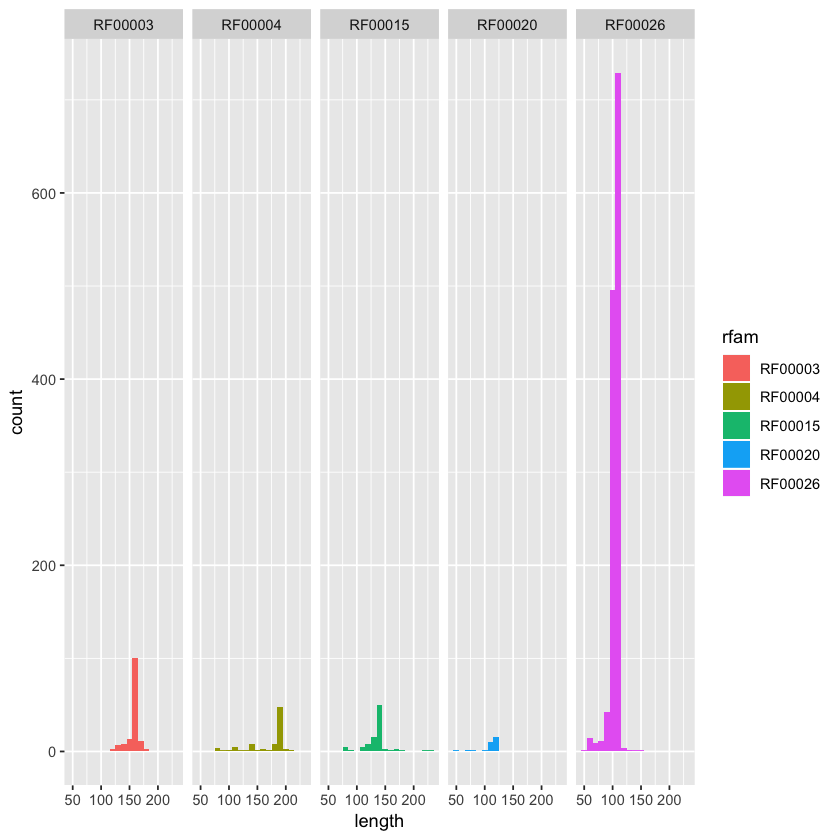

In [14]:
# Plot length with snRNAs binned by rfam model

ggplot(data=genes.geneloc, aes(x=length, fill=rfam)) +
    geom_histogram(binwidth = 10) +
    facet_grid(. ~ rfam, )

In [15]:
mean(genes.geneloc[genes.geneloc$rfam == "RF00026",]$length)

[1] 104.1221

In [16]:
nrow(genes.geneloc[genes.geneloc$rfam == "RF00020",])

[1] 31

In [17]:
describeBy(genes.geneloc$length, genes.geneloc$rfam)


 Descriptive statistics by group 
group: RF00003
   vars   n   mean    sd median trimmed  mad min max range  skew kurtosis  se
X1    1 145 158.89 10.82    163  160.69 2.97 120 176    56 -1.73     2.72 0.9
------------------------------------------------------------ 
group: RF00004
   vars  n   mean    sd median trimmed  mad min max range  skew kurtosis   se
X1    1 90 170.08 33.87    190  176.06 5.93  79 212   133 -1.32     0.48 3.57
------------------------------------------------------------ 
group: RF00015
   vars  n   mean    sd median trimmed  mad min max range skew kurtosis   se
X1    1 97 135.34 22.59    140  135.59 5.93  82 230   148  0.6     4.54 2.29
------------------------------------------------------------ 
group: RF00020
   vars  n   mean    sd median trimmed  mad min max range  skew kurtosis   se
X1    1 31 108.84 17.14    116   113.2 1.48  50 120    70 -2.24     3.79 3.08
------------------------------------------------------------ 
group: RF00026
   vars    n   mean 

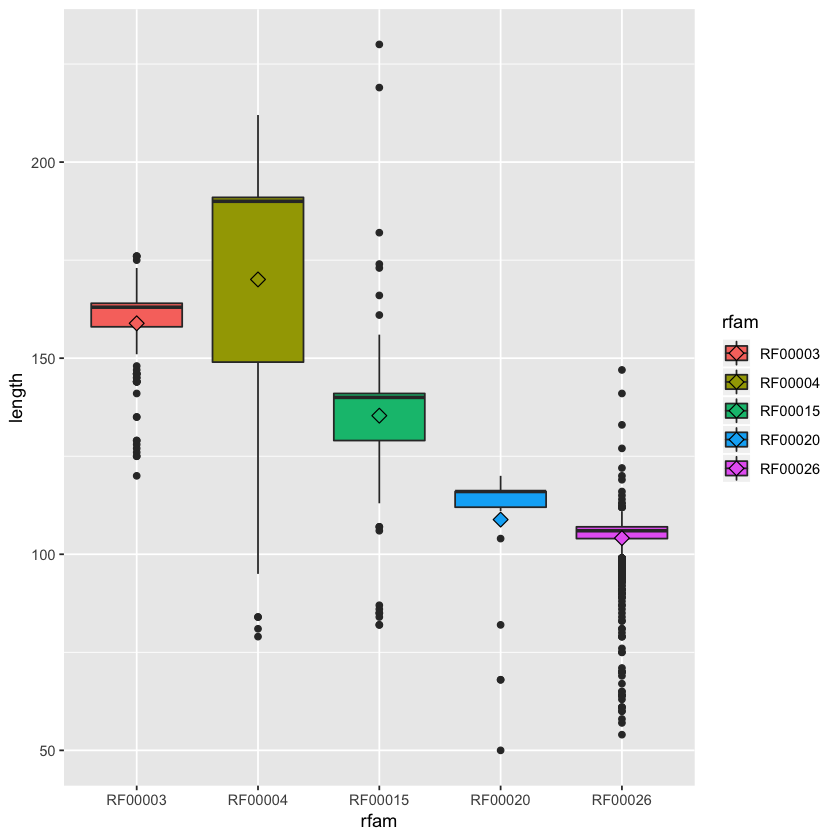

In [131]:
ggplot(data=genes.geneloc, aes(x=rfam, y=length, fill=rfam)) +
    geom_boxplot(notch=FALSE) +
    stat_summary(fun.y=mean, geom="point", shape=23, size=3)

## Structural stability

In [19]:
# Get the sequences of all the snRNA genes

seq <- getSequence(id=genes.geneloc$ensembl_gene_id,
                  type="ensembl_gene_id",
                  seqType="gene_exon",
                  mart=ensembl)


In [20]:
genes.geneloc <- merge(genes.geneloc, seq, by="ensembl_gene_id")

In [21]:
head(genes.geneloc)

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length,gene_exon
ENSG00000194297,RNU1-75P,1,119331397,119331525,-1,RF00003,129,ATATTTATTTGGCAGGGGAGATACCATGATCACGAAGATTTTCCGAGGGCAAGGCTTATCCATTGCACTACGGTTGTACTGACCCCTGTGATTTACTATAGCTTTGCAAAAAGACCACTGCAACCTTAC
ENSG00000195024,RNU1-15P,7,21381363,21381506,1,RF00003,144,ATACTCGTCTGGCAGGGAAGATAAAATGATCATGAAGGTGGCTTTCCCAGGGTGAGATTTATTTATTGCACTCTGGGTGTGCAGACCCCTGCAATTTCCCCGAAAGTGGGAAACTTGGCTGCATAATTTGTGTTCTTCCTTGGT
ENSG00000199217,RNU6-1123P,11,119656311,119656416,1,RF00026,106,GTGCTTGCTTCGGCAGCACATGTACTAAAATTGCAACGATACAGAGACGATTAGCATGGCCCTGTGCAAAGATGACATGCAAATTTGTGAAGCATCACATTAAAAA
ENSG00000199219,RNU6-500P,5,173362134,173362240,-1,RF00026,107,GTGCTCATTTTGGCACCACATATACTAAAATTGGAACAATACAGAGAAAATTAGCATGACCCCTGTGCAAGGATGACACAAAAATTCATGAAGCATGACATTAAAAA
ENSG00000199226,RNU6-50P,X,46517766,46517868,1,RF00026,103,GTCTAAAATTGGAACATATACTAAAATTGGAACAATACAGAGAAGATTAGCATGGCTCCTGTGTAAGGATGACGTGCAAATTTGTCAAGGGTTTCATTTTTTT
ENSG00000199237,RNU6-834P,12,49593104,49593213,1,RF00026,110,GTGCTCACTTCGGTAGCACATATACTAAAGTTGGAATAATACAGAGAAGACTACTAGCATGGCCTCTGTGCAAGGATGACACACAAATTCATGAAGTGTTCCAGTAAATA


In [22]:
# First need to print sequence of each snRNA to file so that it can be folded

for (row in 1:nrow(genes.geneloc)) {
    snrna.header <- paste0(">", genes.geneloc[row, "ensembl_gene_id"])
    snrna.seq <- genes.geneloc[row, "gene_exon"]
    
    snrna.fn <- paste0(genes.geneloc[row, "ensembl_gene_id"], ".fa")
    fileConn <- file(paste0("/Users/rotation/Auguste/folding/", snrna.fn))
    
    writeLines(c(snrna.header, snrna.seq), fileConn)
    close(fileConn)
}

In [23]:
nrow(genes.geneloc)

[1] 1673

### Folded with RNAalifold, now import text file with results

In [ ]:
# command used to fold each snRNA and dump the result in a text file: 
# for file in *.fa; do echo $file; RNAalifold -f F; done>RNAalifold_log.txt

In [24]:
fileName <- "/Users/rotation/Auguste/folding/RNAalifold_log.txt"
conn <- file(fileName, open="r")
lin <- readLines(conn)

In [102]:
dG_list <- list()
for (i in 1:length(lin)) {
    if (i %% 3 == 1) {
        snrna <- strsplit(lin[i], ".", fixed=TRUE)[[1]][1]
        next
        } else if (i %% 3 == 0) {
            tmp <- strsplit(lin[i], "=", fixed=TRUE)[[1]][1]
            dG <- trimws(strsplit(tmp, "(", fixed=TRUE)[[1]][length(strsplit(tmp, "(", fixed=TRUE)[[1]])])
            dG_list[[ snrna ]] <- dG
        }
}

In [103]:
dG_df = do.call(rbind, dG_list) # convert list to matrix

In [104]:
gids <- rownames(dG_df)

In [107]:
dG_df <- cbind(dG_df, ensembl_gene_id = gids)

In [109]:
class(dG_df)

[1] "matrix"

In [110]:
dG_df <- data.frame(dG_df)

In [112]:
genes.geneloc <- merge(genes.geneloc, dG_df, by="ensembl_gene_id")

In [119]:
names(genes.geneloc)[10] <- "dG"

In [382]:
genes.geneloc[grep("RNU2-1", genes.geneloc$hgnc_symbol),]

,ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length,gene_exon,dG,name
1001,ENSG00000222222,RNU2-17P,1,150236967,150237156,1,RF00004,190,ATCGCTTCTCTGCCTTTTGGCTAAGATCAAGTGTAGGATCTGTTCTTAACAGTTTAATATCTGATATATTTTCTATCCGAGTCCAATATATTAAATGGATTTGGGGAGCAGGAAGACGGAATAGGAGCTTGCTTGTTCACTTCACGCATCGATCTGGTATTGCAGTACCTCCAGGAACAGTGCACCCCCT,-49.1,RNU2-17P
1064,ENSG00000222624,RNU2-15P,1,65415816,65416006,1,RF00004,191,ATTGCTTTTTGGCCTTTTGGCTAAAATAAATGTAGCATCTAATTTTATCAGTTTAACATCTGATATGTCTTCTATCCATGTACAATATTTTAAATGGATTTTGTGGAGCAGGGAGATGGAATAGGAGTTTCCCCCACCCATTCCACACATCAGCCTGGTAATGCAGTAACTGCAGGAATAGTTCACCTCCG,-44.3,RNU2-15P
1070,ENSG00000222644,RNU2-16P,4,75829454,75829589,-1,RF00004,136,ATCGCTTCTTGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGAGTGAGACCTTGTCTCACAACCAATAAATAAATAAAGTCAAATATATGGCTGCAAAGACTTCAAAACTAAAAGCCATTGCTACA,-35.9,RNU2-16P
1116,ENSG00000222985,RNU2-14P,14,65124352,65124542,-1,RF00004,191,ATCACTTCTTGGTCTTTTGGCTAAGATCAAGTATAGTATCTGTTTTTATCAGTTTCATATCTGATATGTCCTCTATCCAAGGACAATATATTAAATGGATTTTTGGAAACAGGAGATGGAATAGGAGCTTGCTACATCCACTCCACACATTGACCTGATATTGCAGTACTTCCAGGAACAGTGCACCCAAA,-46.2,RNU2-14P
1133,ENSG00000223156,RNU2-18P,10,16476003,16476164,1,RF00004,162,ATTGCTTCTTGGCCTTTTGGCAAAGATCAAGTGTAGTGTCTGTTCTTATCAGTTTAATAATCATAATCCTGAACATTTATATATTATTATTATTATTTTGAGATGGAGCCTCGCTCTGTTGCCCAGGCTGGAGTGCAATGGTACGGCCTTGGCTCACTACAA,-43.9,RNU2-18P
1190,ENSG00000239122,RNU2-11P,3,195928589,195928775,-1,RF00004,187,ATTCTTTCTCAGCCTTTCGGCAAAGATTAAGTGTAGTCTATATTATTAGTTTAGTATTTGATATGTCCTCTATCTGAGGACAATATATTAAATGGGCGTCTAGAGCAAGAAAATAGAATAGGAGCTTGTTCTGTCCATTCCACTCATTAATCTGATGTTGCGGTATCTGGTGCCTGGAGAAGGAGAT,-52.1,RNU2-11P
1198,ENSG00000251718,RNU2-13P,2,11561194,11561306,1,RF00004,113,ATTGCTTCTCGGCCTTTTGGCTAAGACCAAGTGTAGTATCTGTTCTTATCAGTTTAAAAAAAGCTTCCTACATCCATACCATACCTGACCCTGTTATAGAATGGCTATTTGTA,-15.2,RNU2-13P
1327,ENSG00000252184,RNU2-10P,3,62118300,62118510,-1,RF00004,211,AACACTTCTCAGCCTTTTGGCTAAGATCAAGTGTAGAATTTGCTCTTAACTGGTTAAACACAAGGTCTTCCAAGTCAGGTTGCCTTGGTTCAAATTACACTTCTATCATGGATGAGGTGTGACAAGGGCCAGCACACTATGACCACCAAGGCAAATCCCACCCACAGACTGCATCTGTAAATAAAGTTTTATTGGAACACAGTCAGGTCCA,-54.9,RNU2-10P
1554,ENSG00000253025,RNU2-12P,1,176243862,176244029,-1,RF00004,168,ATCACTTCTCAGCCTTTTGGCTAAGATCAAGTGTAGAAATTCTTCTTCCCCATGCGTTATACCACACTCACAGGGCTCCAGTGTGATCACAGTGAATCACAATTGAAAGAGATCCAAGGCCAAGACTTTTTCTGAGGAGACTACAGGAAAGTCCAGAGAAAACAGGGA,-35.8,RNU2-12P
1569,ENSG00000253097,RNU2-19P,1,205566716,205566799,1,RF00004,84,ATCGTTTCTCAGCCTTTTGGCAAGACCAAGTGTAGTATCTGTTCTTATCAGATATTGGTATCTGCAGGCACTCCTGGAACCAAT,-18.8,RNU2-19P


In [ ]:
#dG was a factor, had to convert back to numeric
genes.geneloc$dG <- as.numeric(levels(genes.geneloc$dG))[genes.geneloc$dG] 

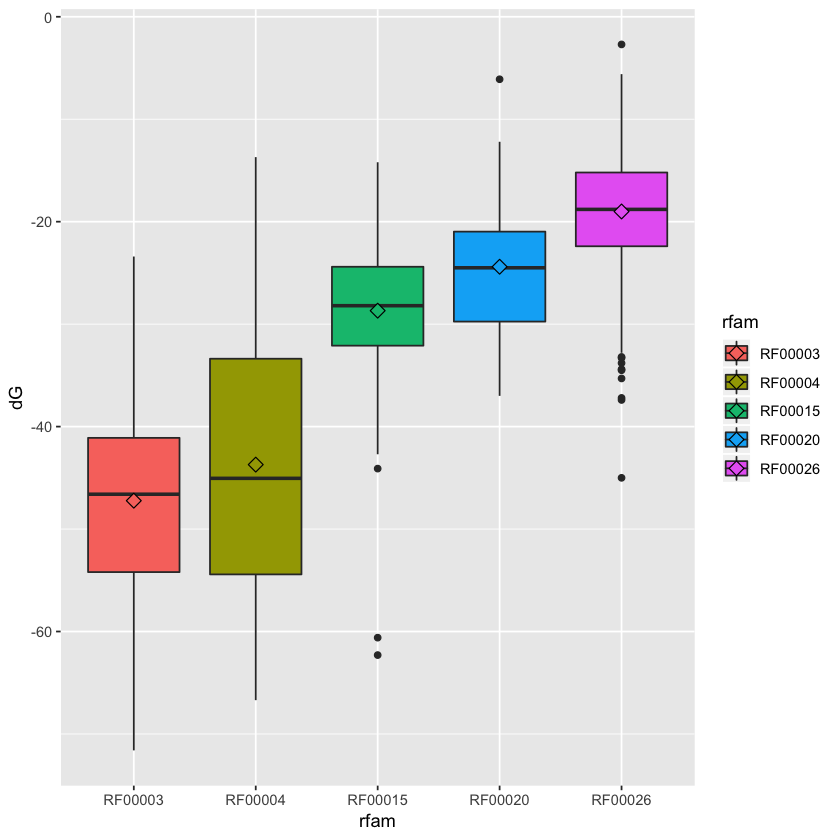

In [136]:
ggplot(data=genes.geneloc, aes(x=rfam, y=dG, fill=rfam)) +
    geom_boxplot(notch=FALSE) +
    stat_summary(fun.y=mean, geom="point", shape=23, size=3)

In [138]:
unique(genes.geneloc$rfam)

[1] "RF00003" "RF00026" "RF00015" "RF00020" "RF00004"

### Write one fasta for each core spliceosome snRNA

In [ ]:
cM.df <- merge(cM.df, genes[, c("name", "ensembl_gene_id")], by="ensembl_gene_id") # add names too

In [340]:
genes.geneloc <- merge(genes.geneloc, genes[, c("name", "ensembl_gene_id")], by="ensembl_gene_id")

In [342]:
for (i in unique(genes.geneloc$rfam)) {
    fn <- paste0(i, ".fas")
    fileConn <- file(open = "a", paste0("/Users/rotation/Auguste/", fn))
    sub <- genes.geneloc[genes.geneloc$rfam == i,]
    
    for (row in 1:nrow(sub)) {
        
        snrna.header <- paste0(">", sub[row, "name"])
        snrna.seq <- sub[row, "gene_exon"]
    
        writeLines(c(snrna.header, snrna.seq), fileConn)     
        }
    
    close(fileConn)
}


## Align with Clustal, create tree to identify groups/outliers

In [312]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("msa")

Bioconductor version 3.7 (BiocInstaller 1.30.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.7 (BiocInstaller 1.30.0), R 3.5.0 (2018-04-23).
Installing package(s) ‘msa’



The downloaded binary packages are in
	/var/folders/0f/k8npdkqd7m1067k8c92p9fp40000gp/T//RtmplAID41/downloaded_packages


installation path not writeable, unable to update packages: cli, evaluate,
  fansi, foreign, ggplot2, htmlwidgets, later, MASS, mgcv, mime, ps, R6, Rcpp,
  rlang, survival, webshot
Old packages: 'devtools', 'digest', 'tinytex', 'xfun'


In [153]:
# Default parameters, used web application: https://www.ebi.ac.uk/Tools/msa/clustalo/
# Also outputs a neighbor-joining tree without distance corrections

# Initially did the alignment using the web application, then eventually downloaded and used the msa package.


In [337]:
library(msa)

In [338]:
system.file("tex", "texshade.sty", package="msa")

[1] "/Users/rotation/Library/R/3.5/library/msa/tex/texshade.sty"

In [346]:
u1 <- readAAStringSet("/Users/rotation/Auguste/RF00003.fas")

In [348]:
u1.algn <- msa(u1)

use default substitution matrix


In [352]:
print(u1.algn, show="complete")


MsaAAMultipleAlignment with 145 rows and 266 columns
      aln (1..52)                                          names
  [1] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNU1-3
  [2] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RF00003_ENSG00000...
  [3] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNU1-4
  [4] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNU1-2
  [5] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNVU1-18
  [6] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNU1-1
  [7] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNU1-27P
  [8] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNU1-28P
  [9] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACCATGATCA---CG RNVU1-7 
  ... ...
[138] ----ATACTT--ACCTGG--TAAATGAGAT-------TCCATGACCA----T RNU1-64P
[139] ----ATGCTT--ACCTGA--CAGGGGAGAT-------ACCATGATCA---CA RNU1-38P
[140] ----ATACTT--ACCTGG--CAGGGGAGAT-------ACTATGATCA---CG RNU1-88P
[141] ----ATATTT--ATTTGG--CAGGGGAGAT-------ACCATGAT

In [ ]:
# In service of eventually looking for Sm-binding sites, folded snRNAs using mFold so I could get a sense
# of where the poly-U region fell (expecting t)

### U1

<img src="pics/u1.png" width="500">

### U2

<img src="pics/u2.png" width="500">

In [376]:
u2 <- readAAStringSet("/Users/rotation/Auguste/RF00004.fas")
u2.algn <- msa(u2)
print(u2.algn, show="complete")

use default substitution matrix

MsaAAMultipleAlignment with 90 rows and 266 columns
     aln (1..53)                                           names
 [1] ATCACTT-CTCAACCTTTTGGCTAAGAAC-AAGTGTAGTATCTGTT----CTT RNU2-41P
 [2] ATCGCTT-CTCGGCCTTTTAGCTAAGATC-AAGTGGAGTATCTGTT----CTT RF00004_ENSG00000...
 [3] ATCGCTT-CTTAGCCTTTTGGCTAAGATC-AAGTGTAGTATCTATT----CCT RNU2-35P
 [4] AACACTT-CTCAGCCTTTTGGCTAAGATC-AAGTGTAGAATTTGCT----CTT RNU2-10P
 [5] ACCACTT-CTCAGCCTTTTGGCTAAGATC-AAGTGTAGTGTCTGTT----CTT RNU2-34P
 [6] TTTGCTT-CTCAGCCTTTTGGCTAAGATC-AAGTGTAGTATCTGTT----CTT RNU2-28P
 [7] ATTGCTT-CTCAGTCTTTTGGCTAAGATC-AAGTGTAGAATCTGTT----CTT RF00004_ENSG00000...
 [8] ATTGCTT-GTCAGCCTTTTGGCTAAGATC-AAGTGTAGCATCTGTT----CTT RNU2-72P
 [9] ATCGCTT-CTCGGCCTTTTGGCTAAGATC-AAGTGTAGTATCTGTT----CTT RNU2-38P 
 ... ...
[83] ATCACTT-CTTGGCCTTTTGGCTAAGATC-AAGTGTAGTAAATGT------TT RF00004_ENSG00000...
[84] ATCACTT-CTCAGCCTTTTGGCTAAGATC-AAGTGTAGTATCTGTT----TTT RNU2-22P
[85] ATCATTT-ATCGGCCTTTTGGCTAAGAAC-AAGTGTAGTATCTGTT----C

## Visualize positions of genes on chromosomes

In [174]:
#install.packages("chromoMap")

Installing package into ‘/Users/rotation/Library/R/3.5/library’
(as ‘lib’ is unspecified)



The downloaded binary packages are in
	/var/folders/0f/k8npdkqd7m1067k8c92p9fp40000gp/T//RtmplAID41/downloaded_packages


In [175]:
library(chromoMap)

In [179]:
head(genes.geneloc)

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length,gene_exon,dG
ENSG00000194297,RNU1-75P,1,119331397,119331525,-1,RF00003,129,ATATTTATTTGGCAGGGGAGATACCATGATCACGAAGATTTTCCGAGGGCAAGGCTTATCCATTGCACTACGGTTGTACTGACCCCTGTGATTTACTATAGCTTTGCAAAAAGACCACTGCAACCTTAC,-26.2
ENSG00000195024,RNU1-15P,7,21381363,21381506,1,RF00003,144,ATACTCGTCTGGCAGGGAAGATAAAATGATCATGAAGGTGGCTTTCCCAGGGTGAGATTTATTTATTGCACTCTGGGTGTGCAGACCCCTGCAATTTCCCCGAAAGTGGGAAACTTGGCTGCATAATTTGTGTTCTTCCTTGGT,-46.2
ENSG00000199217,RNU6-1123P,11,119656311,119656416,1,RF00026,106,GTGCTTGCTTCGGCAGCACATGTACTAAAATTGCAACGATACAGAGACGATTAGCATGGCCCTGTGCAAAGATGACATGCAAATTTGTGAAGCATCACATTAAAAA,-20.8
ENSG00000199219,RNU6-500P,5,173362134,173362240,-1,RF00026,107,GTGCTCATTTTGGCACCACATATACTAAAATTGGAACAATACAGAGAAAATTAGCATGACCCCTGTGCAAGGATGACACAAAAATTCATGAAGCATGACATTAAAAA,-15.8
ENSG00000199226,RNU6-50P,X,46517766,46517868,1,RF00026,103,GTCTAAAATTGGAACATATACTAAAATTGGAACAATACAGAGAAGATTAGCATGGCTCCTGTGTAAGGATGACGTGCAAATTTGTCAAGGGTTTCATTTTTTT,-19.7
ENSG00000199237,RNU6-834P,12,49593104,49593213,1,RF00026,110,GTGCTCACTTCGGTAGCACATATACTAAAGTTGGAATAATACAGAGAAGACTACTAGCATGGCCTCTGTGCAAGGATGACACACAAATTCATGAAGTGTTCCAGTAAATA,-20.8


In [293]:
cM.df <- genes.geneloc[,cbind('ensembl_gene_id', 'chromosome_name', 'start_position', 'rfam')]

In [294]:
cM.df <- merge(cM.df, genes[, c("name", "ensembl_gene_id")], by="ensembl_gene_id") # add names too

In [295]:
cM.df['chrom'] <- paste0("chr", cM.df$chromosome_name)

In [296]:
head(cM.df)

ensembl_gene_id,chromosome_name,start_position,rfam,name,chrom
ENSG00000194297,1,119331397,RF00003,RNU1-75P,chr1
ENSG00000195024,7,21381363,RF00003,RNU1-15P,chr7
ENSG00000199217,11,119656311,RF00026,RNU6-1123P,chr11
ENSG00000199219,5,173362134,RF00026,RNU6-500P,chr5
ENSG00000199226,X,46517766,RF00026,RNU6-50P,chrX
ENSG00000199237,12,49593104,RF00026,RNU6-834P,chr12


In [297]:
cM.df <- cM.df[, c(5, 6, 3, 4)]

In [298]:
head(cM.df)

name,chrom,start_position,rfam
RNU1-75P,chr1,119331397,RF00003
RNU1-15P,chr7,21381363,RF00003
RNU6-1123P,chr11,119656311,RF00026
RNU6-500P,chr5,173362134,RF00026
RNU6-50P,chrX,46517766,RF00026
RNU6-834P,chr12,49593104,RF00026


In [299]:
names(cM.df)[3] <- "start"

In [300]:
head(cM.df)

name,chrom,start,rfam
RNU1-75P,chr1,119331397,RF00003
RNU1-15P,chr7,21381363,RF00003
RNU6-1123P,chr11,119656311,RF00026
RNU6-500P,chr5,173362134,RF00026
RNU6-50P,chrX,46517766,RF00026
RNU6-834P,chr12,49593104,RF00026


In [274]:
#install.packages("tidyr")

Installing package into ‘/Users/rotation/Library/R/3.5/library’
(as ‘lib’ is unspecified)



The downloaded binary packages are in
	/var/folders/0f/k8npdkqd7m1067k8c92p9fp40000gp/T//RtmplAID41/downloaded_packages


In [301]:
cM.df <- separate(cM.df, rfam, into=cbind("bleh", "num"), sep="RF")

In [302]:
head(cM.df)

name,chrom,start,bleh,num
RNU1-75P,chr1,119331397,,00003
RNU1-15P,chr7,21381363,,00003
RNU6-1123P,chr11,119656311,,00026
RNU6-500P,chr5,173362134,,00026
RNU6-50P,chrX,46517766,,00026
RNU6-834P,chr12,49593104,,00026


In [303]:
cM.df['data'] <- as.numeric(cM.df$num)

In [304]:
head(cM.df)

name,chrom,start,bleh,num,data
RNU1-75P,chr1,119331397,,00003,3
RNU1-15P,chr7,21381363,,00003,3
RNU6-1123P,chr11,119656311,,00026,26
RNU6-500P,chr5,173362134,,00026,26
RNU6-50P,chrX,46517766,,00026,26
RNU6-834P,chr12,49593104,,00026,26


In [308]:
drops <- c("bleh", "num")
cM.df <- cM.df[, !(names(cM.df) %in% drops)]

In [309]:
head(cM.df)

name,chrom,start,data
RNU1-75P,chr1,119331397,3
RNU1-15P,chr7,21381363,3
RNU6-1123P,chr11,119656311,26
RNU6-500P,chr5,173362134,26
RNU6-50P,chrX,46517766,26
RNU6-834P,chr12,49593104,26


In [310]:
cM <- chromoMap(cM.df, type="heatmap-single") # thought could perhaps hijack the heatmap functionality to display the different snRNAs in different colors

In [311]:
chromoMapToHTML(cM, file="snRNA_map.html", dir="/Users/rotation/Auguste")

File saved at: 
 /Users/rotation/Auguste/snRNA_map/

In [ ]:
# took a screenshot from this html and moved to pics folder

In [213]:
# failed attempt at getting the results to display inline
library(IRdisplay)
htmlwidgets::saveWidget(cM, "/Users/rotation/Auguste/snRNA_map/snRNA_map.html")
display_html('<iframe src="/Users/rotation/Auguste/snRNA_map/snRNA_map.html" width=100% height=450></iframe>')

ERROR: Error in htmlwidgets::saveWidget(cM, "/Users/rotation/Auguste/snRNA_map/snRNA_map.html"): Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md


In [218]:
# and again
rawHTML = base64enc::dataURI(mime = "text/html;charset=utf-8", file = "/Users/rotation/Auguste/snRNA_map/snRNA_map.html")
display_html(paste("<iframe src=", rawHTML, "width=100% height=450></iframe>", sep = "\""))
unlink("/Users/rotation/Auguste/snRNA_map/snRNA_map.html")

Warning message in file(file, "rb"):
“cannot open file '/Users/rotation/Auguste/snRNA_map/snRNA_map.html': No such file or directory”

ERROR: Error in file(file, "rb"): cannot open the connection


In [3]:
# Result (should have given them different numbers rather than just using Rfam model numbers (threw off the range), )
# or just used a different tool

<img src="pics/snRNA_loci.png" width="500">

## Determine copy number (i.e. how many are identical?)

In [6]:
# Thought initially might do pairwise string comparisons, did not do that (just selected full-length sequences that 
# met a certain free energy prediction criterion)

In [313]:
library(Biostrings)

In [316]:
a <- DNAString(c("ACTAT")) # comparing sequences using BioStrings objects
b <- DNAString(c("ACGGT"))

In [317]:
a == b

[1] FALSE

In [321]:
genes.geneloc.uniq <- unique(genes.geneloc$gene_exon)

In [329]:
library("dplyr")


Attaching package: ‘dplyr’

The following object is masked from ‘package:ggplot2’:

    vars

The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union

The following object is masked from ‘package:XVector’:

    slice

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:biomaRt’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, sete

In [331]:
seq.summary <- genes.geneloc %>% group_by(rfam, gene_exon) %>% summarize(count=n())

In [336]:
seq.summary["count" > 1,]

rfam,gene_exon,count
RF00003,AAAAATCTTGACAGAGGAGCTATCATGAGCAAGAAGGTTGTTTTCCCAGTCAAGGCTTATCAATTGCATTCCAGATGTGCTGACCCCTGCAATTTCCCCATACGTGGGAAACTAGACTGCATAATTTGTGGTAGTGGGGGTCTGTGATCCCACTTTCCCCTG,1
RF00003,AAACTTCTCTGCCAGGGGAGATACCATGATCACAAAGGTGGCTTTCTCAGGGAAAGGCTGATTTATTGCACTCCAGATGTGCTGACCCCTGAGATTTCTCCAAATGTGGGAAACTCAGCTGCATAATTTGTGGAAGCGAAGGACTGTGTTTGTGCTTTCATGTG,2
RF00003,ACACTCACTTAGCAGGGGAGACATCATGATCACAAAGGTGATTTTCCCAGGGCAAAGCTTATCCATTGCACTCCACATGTGCTGACCCGTCATTTTCCCAAATGTGATAAACTCAACTGCATAATTGTGGCAGTAGGGAACTGCATTTACACTTTCCCC,1
RF00003,ACACTTACCTGGAAGGGAAGATACCATGATCATGAAGGTGGTTTTCCCAGGGCGAGGCTTGTCTATTGCACACTTCGAGAACCATTTACTTGTATTACTGCTAAAACATCTGAAATGTGTCTTTCCTGTTGCCAATCATGGCTTCTTTCTTCCTTCCTTAGAGCTGCAGCTCTAA,1
RF00003,ACACTTACCTGGCAGGAGAGACACCAGGATCAGGAAAGTGTTTTCCCAAGGGAGGCTCCTTGTGCTGACTCTCATGATTTCCCCAAGTGTAGGACACTCAACTGCATAATCTGTGTAGTGGGAGATAGTGTTTATGCCCTCCCC,1
RF00003,ACACTTACCTGGCAGGGGAGATAGTATGATCATGAAAGTGGTTTTTCCAGAGCGAGGCTTATCCATTGCACTCCGGATGTGTTGACCTCTGCGATTTCCCCAACTGTGGGAAACTCGACTGCGTAATTTGTGGTAGTGGGGGACTGCGTTCGCGCTTTCCCCTG,1
RF00003,ACACTTACCTGGCAGTGGAAATACCATGATCACGAAGGTGGTTTTTCCATGGCCAGCCTTATCCATTGCACTCAGATGTGTTGACCCCTGCAATTTCCCCAAATGTGAAAAACTTGACTGCATAATTTGTGATAGTAGGACTTTCATTCACACTTTCCCC,1
RF00003,ACACTTACTTGGCAGAAAGAATGTCATCGTCAAGAAGATGGTTCTCCCAGTACTAGTCTTCTCCCTCGCACTCCAGACTTGCTGGCCCCTGCGATTTCCCCAGTGGGAAACTCTACTGTGGAACTTGTCCCAGTGCGAGACTGCACTCATGTTCTCCCC,1
RF00003,ACACTTATCTGGAAGGGGAGATACCATAATCATGAAGGTGGTTTTTCCAGGGTGAGGCTAATCCATTGAACTCTGGGTGTGCTGACCCCTGTGATTTCCCCAAATGTGGGAAACTCCACTGCACAATTGGTGTTGGTGGAGGACTGTGTTCCTACTCTGCCTTGG,1
RF00003,ACACTTATCTGGCTGGGGAGATACCATGATCATGAAGGTGGTTCTCAGAGTGAGGCTCATCCATTGCACTTTGGTTGTGCTGACCCCTGTGATTTCCCCAAATGCAGAATTTGTAGTAGTGAGGGACTGTGTTCGTGCTTTCCCCTG,1


In [334]:
write.csv(seq.summary, file="/Users/rotation/Auguste/snRNA_seq_summary.csv")

## Choose a subset of U2s to focus on

In [396]:
u2 <- genes.geneloc[genes.geneloc$rfam == 'RF00004',]

### Examine distribution of free energies for all U2s

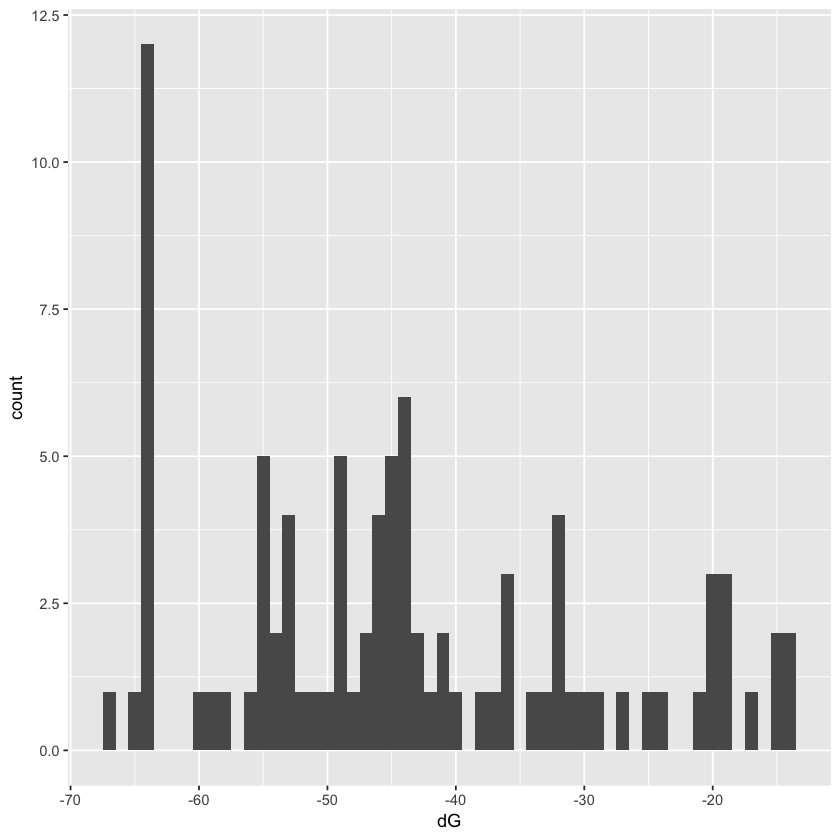

In [433]:
ggplot(data=u2, aes(x=dG)) +
    geom_histogram(binwidth = 1)

In [436]:
u2_sub <- u2[u2["dG"] <= -62, ]

In [421]:
u2_sub

,ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length,gene_exon,dG,name
1033,ENSG00000222414,RNU2-59P,10,101364845,101365035,-1,RF00004,191,ATCACTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTCATCAGTTTAGTATCTGATATGTCCTCTATCTGAGGACAATATATTAAATAGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCATGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACTCGCT,-66.7,RNU2-59P
1593,ENSG00000273709,,17,43241180,43241370,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000273709
1597,ENSG00000274062,,17,43284139,43284329,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274062
1602,ENSG00000274432,,17,43245674,43245864,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274432
1603,ENSG00000274452,,17,43290291,43290481,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACTTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274452
1604,ENSG00000274585,RNU2-1,17,43233787,43233977,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RNU2-1
1608,ENSG00000274862,,17,43277978,43278168,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274862
1612,ENSG00000275219,,17,43296425,43296615,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000275219
1616,ENSG00000275616,,17,43239921,43240111,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000275616
1622,ENSG00000276596,,17,43266633,43266823,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000276596


In [443]:
fileConn <- file(open="a", "/Users/rotation/Auguste/u2_subset.fas")

for (row in 1:nrow(u2_sub)) {
    
    snrna.header <- paste0(">", u2_sub[row, "name"])
    snrna.seq <- u2_sub[row, "gene_exon"]
    
    writeLines(c(snrna.header, snrna.seq), fileConn) 

}

close(fileConn)

In [447]:
u2_sub$ensembl_gene_id

[1] "ENSG00000222414" "ENSG00000273709" "ENSG00000274062" "ENSG00000274432"
 [5] "ENSG00000274452" "ENSG00000274585" "ENSG00000274862" "ENSG00000275219"
 [9] "ENSG00000275616" "ENSG00000276596" "ENSG00000277903" "ENSG00000278048"
[13] "ENSG00000278591" "ENSG00000278774"

In [448]:
up <- getSequence(id=u2_sub$ensembl_gene_id, 
                  type="ensembl_gene_id", 
                  seqType="gene_flank", 
                  upstream=500, 
                  mart=ensembl)

down <- getSequence(id=u2_sub$ensembl_gene_id, 
                    type="ensembl_gene_id", 
                    seqType="gene_flank", 
                    downstream=50, 
                    mart=ensembl)

In [449]:
u2_sub

,ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length,gene_exon,dG,name
1033,ENSG00000222414,RNU2-59P,10,101364845,101365035,-1,RF00004,191,ATCACTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTCATCAGTTTAGTATCTGATATGTCCTCTATCTGAGGACAATATATTAAATAGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCATGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACTCGCT,-66.7,RNU2-59P
1593,ENSG00000273709,,17,43241180,43241370,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000273709
1597,ENSG00000274062,,17,43284139,43284329,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274062
1602,ENSG00000274432,,17,43245674,43245864,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274432
1603,ENSG00000274452,,17,43290291,43290481,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACTTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274452
1604,ENSG00000274585,RNU2-1,17,43233787,43233977,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RNU2-1
1608,ENSG00000274862,,17,43277978,43278168,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274862
1612,ENSG00000275219,,17,43296425,43296615,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000275219
1616,ENSG00000275616,,17,43239921,43240111,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000275616
1622,ENSG00000276596,,17,43266633,43266823,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000276596


In [450]:
colnames(up)[colnames(up)=="gene_flank"] <- "gene_flank_up_500"
colnames(down)[colnames(down)=="gene_flank"] <- "gene_flank_down_50"

tmp <- merge(up, down, by="ensembl_gene_id")

u2.flank <- merge(u2_sub, tmp, by="ensembl_gene_id")

u2.flank$gene_plus_flank <- paste0(u2.flank$gene_flank_up_500, u2.flank$gene_exon, u2.flank$gene_flank_down_50)

In [459]:
u2.flank

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,rfam,length,gene_exon,dG,name,gene_flank_up_500,gene_flank_down_50,gene_plus_flank
ENSG00000222414,RNU2-59P,10,101364845,101365035,-1,RF00004,191,ATCACTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTCATCAGTTTAGTATCTGATATGTCCTCTATCTGAGGACAATATATTAAATAGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCATGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACTCGCT,-66.7,RNU2-59P,CCACTGCACTCCAGCCTGTGCAACAAGAGCGAAACTTCGTCTCAAAAAAAATAAAAATAAAAATAAAAAATTTTTAAAAAGAAAAAGAATTAAAGAAAAGAAATATCACCCAGCCTGGGTGACAGAGTGAGTGAGACTGTCTCAAAAAATTAAAAAAAAAAAGGGCCAAGCGCGGTGGCTCACGCCAGTAATCCCAGCACTTTGGAAGGCTGAGGCGGGCAGATCACCTGAGATCCGGAGTTCAAGACCAGCCTGGCCAACATGGAGAAACCCCATCTCTACTAAAACTGCAAAATTAGCTGGGTGTGGTGGTGCATGCCTGTAATCCCAGCTACTCAGGAAGCTAAGGCAGGAGAATCACTTGAACCCGGGAGGTGGAGGTTGCGGTGAGCCGAGATCGCGCCATTGTATTCCAGCCTGGGCACCAAGAGCGAAACTCCATCTTAAAAAAAAAATAAAAATAAAAAAATTTTAAAAAGAAAAAAAGAAAAAGAATTAAA,CCGGGGATACAAAAAAAAAAAAAAAAGAATTAAAAGAAATATCACCTAAA,CCACTGCACTCCAGCCTGTGCAACAAGAGCGAAACTTCGTCTCAAAAAAAATAAAAATAAAAATAAAAAATTTTTAAAAAGAAAAAGAATTAAAGAAAAGAAATATCACCCAGCCTGGGTGACAGAGTGAGTGAGACTGTCTCAAAAAATTAAAAAAAAAAAGGGCCAAGCGCGGTGGCTCACGCCAGTAATCCCAGCACTTTGGAAGGCTGAGGCGGGCAGATCACCTGAGATCCGGAGTTCAAGACCAGCCTGGCCAACATGGAGAAACCCCATCTCTACTAAAACTGCAAAATTAGCTGGGTGTGGTGGTGCATGCCTGTAATCCCAGCTACTCAGGAAGCTAAGGCAGGAGAATCACTTGAACCCGGGAGGTGGAGGTTGCGGTGAGCCGAGATCGCGCCATTGTATTCCAGCCTGGGCACCAAGAGCGAAACTCCATCTTAAAAAAAAAATAAAAATAAAAAAATTTTAAAAAGAAAAAAAGAAAAAGAATTAAAATCACTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTCATCAGTTTAGTATCTGATATGTCCTCTATCTGAGGACAATATATTAAATAGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCATGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACTCGCTCCGGGGATACAAAAAAAAAAAAAAAAGAATTAAAAGAAATATCACCTAAA
ENSG00000273709,,17,43241180,43241370,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000273709,CCGCCCGCGGGCGGCGAAGTAAAGGCCCAGCGCAGCCCGCGCTCCTGCCCTGGGGCCTCGTCTTTCTCCAGGAAAACGTGGACCGCTCTCCGCCGACAGGTCTCTTCCACAGACCCCTGTCGCCTTCGCCCCCGGTCTCTTCCGGTTCTGTCTTTTCGCTGGGCTCGATACGAACAAGGAAGTCGCCCCCAGCGGAGCCCCGGCTCCCCCAGGCAGAAGGCGGCCCCGGGGGGCGGAGTCAACGGCGGAGGCCACGCCCTCTGTGAAAGGGGCGGGGGCATGCAAATTGGAAATGAAAGCCCGGGAACGCCGGAAGAAGCACGGGTGTAAGATTTCCCTTTTCAAAGGCGGAGAATAAGAAATCAGCCCGAGAGTGTAAGGGCGTCAATAGCGCTGTGGACGAGACAGAGGGAATGGGGCAAGGAGCGAGGCTGGGGCTCTCACCGCGACTTGAATGTGGATGAGAGTGGGACGGTGACGGCGGGCGCGAAGGCGAGCGC,CCGGGGATACAACGTGTTTCCTAAAAGTAGAGGGAGGTAAGAGACGGTAG,CCGCCCGCGGGCGGCGAAGTAAAGGCCCAGCGCAGCCCGCGCTCCTGCCCTGGGGCCTCGTCTTTCTCCAGGAAAACGTGGACCGCTCTCCGCCGACAGGTCTCTTCCACAGACCCCTGTCGCCTTCGCCCCCGGTCTCTTCCGGTTCTGTCTTTTCGCTGGGCTCGATACGAACAAGGAAGTCGCCCCCAGCGGAGCCCCGGCTCCCCCAGGCAGAAGGCGGCCCCGGGGGGCGGAGTCAACGGCGGAGGCCACGCCCTCTGTGAAAGGGGCGGGGGCATGCAAATTGGAAATGAAAGCCCGGGAACGCCGGAAGAAGCACGGGTGTAAGATTTCCCTTTTCAAAGGCGGAGAATAAGAAATCAGCCCGAGAGTGTAAGGGCGTCAATAGCGCTGTGGACGAGACAGAGGGAATGGGGCAAGGAGCGAGGCTGGGGCTCTCACCGCGACTTGAATGTGGATGAGAGTGGGACGGTGACGGCGGGCGCGAAGGCGAGCGCATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCTCCGGGGATACAACGTGTTTCCTAAAAGTAGAGGGAGGTAAGAGACGGTAG
ENSG00000274062,,17,43284139,43284329,-1,RF00004,191,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCTTATCAGTTTAATATCTGATACGTCCTCTATCCGAGGACAATATATTAAATGGATTTTTGGAGCAGGGAGATGGAATAGGAGCTTGCTCCGTCCACTCCACGCATCGACCTGGTATTGCAGTACCTCCAGGAACGGTGCACCCCCT,-63.5,RF00004_ENSG00000274062,TCTCCCCGCCCGCGGGCGGCGAAGTAAAGGCCCAGCGCAGCCCGCGCTCCTGCCCTGGGGCCTCGTCTTTCTCCAGGAAAACGTGGACCGCTCTCCGCCGACAGGTCTCTTCCACAGACCCCTGTCGCCTTCGCCCCCGGTCTCTTCCGGTTCTGTCTTTTCGCTGGCTCGATACGAACAAGGAAGTCGCCCCCAGCGGAGCCCCGGCTCCCCCAGGCAGAGGCGGCCCCGGGGGCGGAGTCAACGGCGGAGGCCACGCCCTCTGTGAAAGGGCGGGGCATGCAAATTCGAAATGAAAGCCCGGGAACGCCGGAAGAAGCACGGGTGTAAGATTTCCCTTTTCAAAGGCGGAGAATAAGAAATCAGCCCGAGAGTGTAAGGGCGTCAATAGCGCTGTGGACGAGACAGAGGGAATGGGGCAAGGAGCGAG

In [460]:
fileConn <- file(open="a", "/Users/rotation/Auguste/u2_subset_with_flank.fas")

for (row in 1:nrow(u2.flank)) {
    
    snrna.header <- paste0(">", u2.flank[row, "name"])
    snrna.seq <- u2.flank[row, "gene_plus_flank"]
    
    writeLines(c(snrna.header, snrna.seq), fileConn) 

}

close(fileConn)

In [461]:
# found that upstream and downstream regulatory elements appear to be there for all but RN2-59P

## Compare regulatory regions among very similar U2 snRNA variants

In [8]:
# Upstream and downstream regions look very highly conserved among these variants, with one exception

<img src="pics/u2v_upstream.png">

In [9]:
#           ^^^^ distal sequence element                                                    proximal sequence element should be over here somewhere

<img src="pics/u2v_downstream.png">

In [10]:
# 3' box should be at far right of this image. here we can also see how conserved the snRNA sequence
# itself is, even though in the case of U2-59P 